In [57]:
%matplotlib inline

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import glob

from statsmodels.formula.api import ols

def remove_postfix(s):
    tokens = s.split('.')
    if tokens[-1] in ['col', 'txt', 'mtx', 'edges']:
        tokens = tokens[:-1]
    if tokens[0] in ['out']:
        tokens = tokens[1:]
    return '.'.join(tokens)

# Load network stats
# networks = pd.read_csv('networks/many_files_stats_cleaned.csv', sep=',', index_col='test')
networks = pd.read_csv('networks/network_stats_new.csv', sep=';', index_col='test')
networks['log n'] = np.log(networks['n'])
networks['log max_deg'] = np.log(networks['max_deg'])
networks['log avg_deg'] = np.log(networks['avg_deg'])

networks = networks.sort_values('n')

# Load wcol stats

dframes = []
for filename in glob.glob('networks/best_wcols/*.csv'):
    print(filename)
    dframes.append(pd.read_csv(filename, sep=',', index_col='test'))

wcol = pd.concat(dframes)

# There's some spurious file endings in that file
wcol.index = wcol.index.map(lambda s: s.split('.')[0])

networks = networks[~networks.index.duplicated(keep='first')]

# Merge wcol stats into networks table
for r in range(1,6):
    column = wcol[wcol['rad']==r]['sortdeg1.lsR']
    column = column[~column.index.duplicated(keep='first')]
    networks['wcol'+str(r)] = column
    
print("Loaded data for {} networks".format(len(networks)))
networks

networks/best_wcols/big-network-repo_rep.csv
networks/best_wcols/small-colours_rep.csv
networks/best_wcols/medium-corpus_rep.csv
networks/best_wcols/huge-konect_rep.csv
networks/best_wcols/big-colours_rep.csv
networks/best_wcols/big-konect_rep.csv
networks/best_wcols/small-konect_rep.csv
networks/best_wcols/big-corpus_rep.csv
networks/best_wcols/medium-konect_rep.csv
networks/best_wcols/medium-network-repo_rep.csv
networks/best_wcols/small-network-repo_rep.csv
networks/best_wcols/le_7000-network-repo_rep.csv
networks/best_wcols/medium-colours_rep.csv
networks/best_wcols/small-corpus_rep.csv
Loaded data for 1928 networks


,n,m,avg_deg,max_deg,log n,log max_deg,log avg_deg,wcol1,wcol2,wcol3,wcol4,wcol5
test,,,,,,,,,,,,
Trec3.mtx,2,1,1.00,1,0.693147,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN
Trec4.mtx,3,2,1.33,2,1.098612,0.693147,0.285179,NaN,NaN,NaN,NaN,NaN
out.brunson_southern-women_southern-women,5,8,3.20,4,1.609438,1.386294,1.163151,NaN,NaN,NaN,NaN,NaN
myciel2.col,5,5,2.00,2,1.609438,0.693147,0.693147,NaN,NaN,NaN,NaN,NaN
cage3.mtx,5,7,2.80,4,1.609438,1.386294,1.029619,NaN,NaN,NaN,NaN,NaN
out.brunson_south-africa_south-africa,6,8,2.67,4,1.791759,1.386294,0.982078,NaN,NaN,NaN,NaN,NaN
Trec5.mtx,7,10,2.86,6,1.945910,1.791759,1.050822,NaN,NaN,NaN,NaN,NaN
b1_ss.mtx,7,9,2.57,6,1.945910,1.791759,0.943906,NaN,NaN,NaN,NaN,NaN
rel3.mtx,7,13,3.71,6,1.945910,1.791759,1.311032,NaN,NaN,NaN,NaN,NaN


<h2>Read improved results based on coloring number</h2>

In [68]:
# Load wcol stats based on sreach
dframes = []
for path in glob.glob('networks/*/_rep_LSSReach.csv'):
    print(path)
    dframes.append(pd.read_csv(path, sep=',', index_col='test'))

swcol = pd.concat(dframes)

# Merge wcol stats into networks table
for r in range(1,6):
    column = swcol[swcol['rad']==r]['sortdeg1.lsR']
    column = column[~column.index.duplicated(keep='first')]
    old_column = networks['wcol'+str(r)] 
    merged = old_column.combine(column, lambda x1, x2: x1 if x1 < x2 else x2)
    networks['wcol'+str(r)] = merged    
networks.head()

networks/medium-colours/_rep_LSSReach.csv
networks/small-network-repo/_rep_LSSReach.csv
networks/big-konect/_rep_LSSReach.csv
networks/medium-corpus/_rep_LSSReach.csv
networks/small-corpus/_rep_LSSReach.csv
networks/big-network-repo/_rep_LSSReach.csv
networks/small-konect/_rep_LSSReach.csv
networks/medium-network-repo/_rep_LSSReach.csv
networks/le_70000-network-repo/_rep_LSSReach.csv
networks/big-colours/_rep_LSSReach.csv
networks/huge-corpus/_rep_LSSReach.csv
networks/huge-konect/_rep_LSSReach.csv
networks/big-corpus/_rep_LSSReach.csv
networks/medium-konect/_rep_LSSReach.csv
networks/small-colours/_rep_LSSReach.csv


,n,m,avg_deg,max_deg,log n,log max_deg,log avg_deg,wcol1,wcol2,wcol3,wcol4,wcol5
test,,,,,,,,,,,,
Trec3.mtx,2,1,1.00,1,0.693147,0.000000,0.000000,2.0,2.0,2.0,2.0,2.0
Trec4.mtx,3,2,1.33,2,1.098612,0.693147,0.285179,2.0,2.0,2.0,2.0,2.0
out.brunson_southern-women_southern-women,5,8,3.20,4,1.609438,1.386294,1.163151,4.0,4.0,4.0,4.0,4.0
myciel2.col,5,5,2.00,2,1.609438,0.693147,0.693147,3.0,4.0,4.0,4.0,4.0
cage3.mtx,5,7,2.80,4,1.609438,1.386294,1.029619,3.0,4.0,4.0,4.0,4.0


Finally, drop networks for which we don't have any stats.

In [69]:
networks = networks.dropna()
print("Found data for {} networks".format(len(networks)))

Found data for 1703 networks


<h2>Define helpers for plotting</h2>

In [177]:
from matplotlib.lines import Line2D

latex_label = {'n': '$n$', 'log n': '$\\log n$', 'm': '$m$', 'log m': '$\\log m$',
                'avg_deg': '$\\bar d$', 'max_deg': '$\\Delta$', 
                'log avg_deg': '$\\log \\bar d$', 'log max_deg': '$\\log \\Delta$',
                'radius': '$r$'}
for r in range(1,6):
    latex_label['wcol'+str(r)] = '$\\mathrm{wcol}_'+str(r)+'$'

    
# Helper function for regression plot w/ outliers
def label_point(x, y, val, ax, label_align='left'):
    import matplotlib.transforms as mtrans
    # This translation is on screen-space, not data-space. 
    # Hence we can enter values in pixels.
    if label_align == 'left':
        trans = mtrans.Affine2D().translate(10, 0)
    else:
        trans = mtrans.Affine2D().translate(-10, 0)
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        label = ax.text(point['x'], point['y'], str(point['val']), ha=label_align)
        label.set_transform(label.get_transform() + trans)

def regplot(tab, xlabel, ylabel, legend="upper left", axis=None, bg=None, corr=None, label_pos='left'):
    x,y,labels = tab[xlabel], tab[ylabel], tab.index

    sns.set_style("whitegrid")
    if bg == None:
        bg = '#333333'

    regression = ols("data ~ x", data=dict(data=y, x=x)).fit()
    intercept = regression.params['Intercept']
    slope = regression.params['x']

    if not axis:
        axis = plt.gca()
    
    sns.regplot(x, y, marker='+', ax=axis, 
                scatter_kws={"color":"white"},
                line_kws={
                'color': '#ffdd55',
                'label':"y={0:.2f}x {1:+.2f}".format(slope,intercept)
                })
    if corr:
        fakehandle = Line2D([0], [0], lw=0)
        leg = axis.legend([fakehandle], ['{:.2f}'.format(corr)[1:]], # loc=legend, 
                        bbox_to_anchor=[0, 1], loc='upper left',
                        handlelength=0, handletextpad=0, borderaxespad=.25, borderpad=0, 
                        frameon=False, fontsize=40)
        for text in leg.get_texts():
            text.set_color("white")
    
    axis.set_xlabel(latex_label[xlabel], fontsize=20)
    axis.set_ylabel(latex_label[ylabel], fontsize=20)
    axis.set_facecolor(bg)

In [3]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def colorline(
    x, y, z=None, axis=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=1, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)
    
    if not axis:
        axis = plt.gca()
    axis.add_collection(lc)

    return lc

<h2>Compute correlation matrix</h2>

In [71]:
tab = networks.copy().drop('log avg_deg', axis=1)

labels = tab.columns.tolist()

cols = labels[:-5]
rows = labels[-5:]

cols = [latex_label[s] for s in cols]
rows = [latex_label[s] for s in rows]

print(cols)
print(rows)

# Rows should be wcol1,...,wcol5; columns all other measures

M = pd.DataFrame(np.corrcoef(tab.T), columns=cols+rows, index=cols+rows)

# We are only interested into basic measures vs. wcols
M = M[cols].loc[rows]
M = M[['$n$', '$m$', '$\\Delta$', '$\\bar d$',]]

['$n$', '$m$', '$\\bar d$', '$\\Delta$', '$\\log n$', '$\\log \\Delta$']
['$\\mathrm{wcol}_1$', '$\\mathrm{wcol}_2$', '$\\mathrm{wcol}_3$', '$\\mathrm{wcol}_4$', '$\\mathrm{wcol}_5$']


Let's plot it.

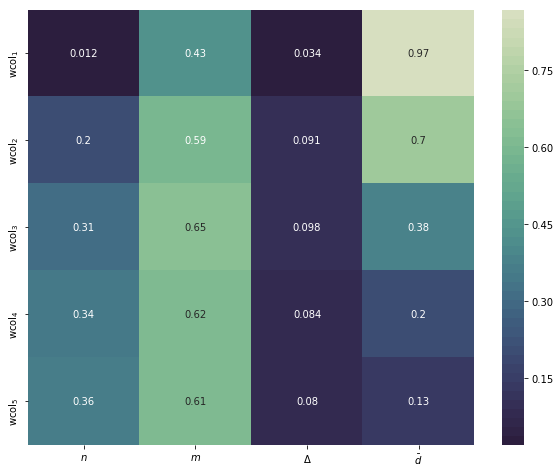

In [72]:
plt.figure(figsize=(10,8))
palette = sns.cubehelix_palette(48, reverse=True, start=.5, rot=-.75)

sns.heatmap(M, cmap=palette, robust=True, annot=True)
# plt.savefig('wcol_correlation.pdf')
# plt.savefig('wcol_correlation.svg')

In [108]:
import matplotlib
subM = M.loc[['$\\mathrm{wcol}_1$', '$\\mathrm{wcol}_3$', '$\\mathrm{wcol}_5$']]

cmap = matplotlib.colors.ListedColormap(palette) # Turn palette into callable cmap(..)
C = subM.applymap(cmap)

colors = [list(map(matplotlib.colors.rgb2hex, c)) for _, c in C.iterrows()]
correlations = [list(v) for _, v in subM.iterrows() ]

correlations

[[0.011733225894863784,
  0.42874886511698995,
  0.03429324704503449,
  0.9708360919996296],
 [0.31380842969618244,
  0.6499189018936459,
  0.098364184375371,
  0.37808806189549254],
 [0.3555145166395455,
  0.611288523612534,
  0.07997660174561835,
  0.13013611496733166]]

<h2>Plot measures against $wcol_1$, $wcol_3$, $wcol_5$</h2>

/home/felix/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


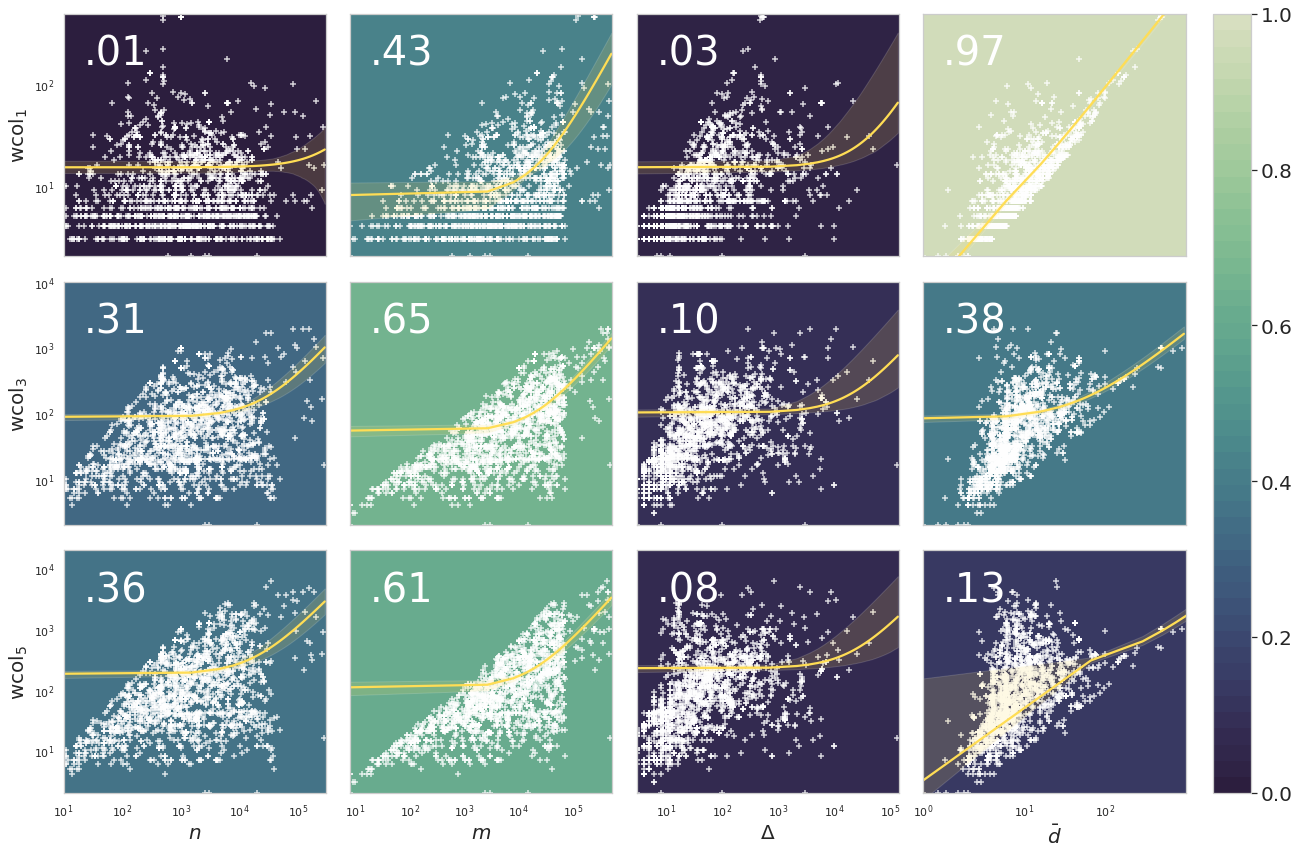

In [178]:
f, axes = plt.subplots(3, 4, figsize=(20,12))

sns.set_palette(sns.color_palette("Set1", 4), 4)

max_n = np.max(networks['n']) * 1.1
max_m = np.max(networks['m']) * 1.1
max_maxdeg = np.max(networks['max_deg']) * 1.1
max_avgdeg = np.max(networks['avg_deg']) * 1.1

wcolsteps = ['wcol1','wcol3','wcol5']
ylims = [500,10000,20000]
inner = [True, True, False]
for wcollabel,ax_row,top,is_inner,cols,corr in zip(wcolsteps,axes,ylims,inner,colors,correlations):
    (ax1,ax2,ax3,ax4) = ax_row
    regplot(networks, 'n', wcollabel, axis=ax1, bg=cols[0], corr=corr[0])
    ax1.set_xscale('symlog')
    ax1.set_yscale('symlog')
    ax1.set_xlim(left=10, right=max_n)
    ax1.set_ylim(bottom=2, top=top)
    ax1.grid(False)
    
    regplot(networks, 'm', wcollabel, axis=ax2, bg=cols[1], corr=corr[1])
    ax2.set_xscale('symlog')
    ax2.set_yscale('symlog')
    ax2.set_xlim(left=8, right=max_m)
    ax2.set_ylim(bottom=2, top=top)
    ax2.grid(False)    
    
    regplot(networks, 'max_deg', wcollabel, axis=ax3, bg=cols[2], corr=corr[2])
    ax3.set_xscale('symlog')
    ax3.set_yscale('symlog')
    ax3.set_xlim(left=3, right=max_maxdeg)
    ax3.set_ylim(bottom=2, top=top)
    ax3.grid(False)

    regplot(networks, 'avg_deg', wcollabel, axis=ax4, bg=cols[3], corr=corr[3])
    ax4.set_xscale('symlog')
    ax4.set_yscale('symlog')
    ax4.set_xlim(left=1, right=max_avgdeg)
    ax4.set_ylim(bottom=2, top=top)
    ax4.grid(False)
    
    for ax in ax_row[1:]:
        ax.get_yaxis().set_visible(False)
    
    if not is_inner:
        continue
        
    for ax in ax_row:
        ax.get_xaxis().set_visible(False)

# This has to be called before adding the color bar
f.tight_layout()
        
# Add colorbar. Dirty hack taken from 
# https://medium.com/data-science-canvas/way-to-show-colorbar-without-calling-imshow-or-scatter-4a378058316
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []

cbar = f.colorbar(sm, ax=axes.ravel().tolist(), shrink=1, pad=0.02)
cbar.set_ticks(np.arange(0, 1.01, 0.2))
cbar.ax.tick_params(labelsize=20) 


# f.savefig('stats_vs_wcol.svg')
# f.savefig('stats_vs_wcol.pdf')

['$n$', '$m$', '$\\bar d$', '$\\Delta$', '$\\log n$', '$\\log \\Delta$']
['$\\mathrm{wcol}_1$', '$\\mathrm{wcol}_2$', '$\\mathrm{wcol}_3$', '$\\mathrm{wcol}_4$', '$\\mathrm{wcol}_5$']


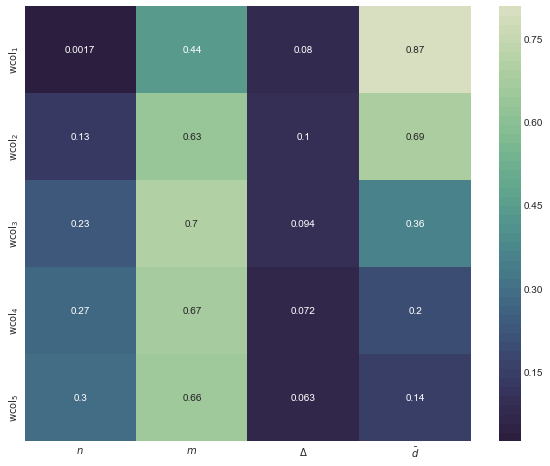

In [6]:
tab = networks.copy().drop('log avg_deg', axis=1)

labels = tab.columns.tolist()

cols = labels[:-5]
rows = labels[-5:]

cols = [latex_label[s] for s in cols]
rows = [latex_label[s] for s in rows]

print(cols)
print(rows)

# Rows should be wcol1,...,wcol5; columns all other measures

M = pd.DataFrame(np.corrcoef(tab.T), columns=cols+rows, index=cols+rows)

# We are only interested into basic measures vs. wcols
M = M[cols].loc[rows]
M = M[['$n$', '$m$', '$\\Delta$', '$\\bar d$',]]

plt.figure(figsize=(10,8))
cmap = sns.cubehelix_palette(48, reverse=True)
cmap = sns.cubehelix_palette(48, reverse=True, start=.5, rot=-.75)
# cmap = plt.get_cmap('RdYlBu_r')

sns.heatmap(M, cmap=cmap, robust=True, annot=True)
# plt.savefig('wcol_correlation.pdf')
# plt.savefig('wcol_correlation.svg')

<h2>Old stuff</h2>

In [ ]:
f, axes = plt.subplots(3, 4, figsize=(20,12))

sns.set_palette(sns.color_palette("Set1", 4), 4)

max_n = np.max(networks['n']) * 1.1
max_m = np.max(networks['m']) * 1.1
max_maxdeg = np.max(networks['max_deg']) * 1.1
max_avgdeg = np.max(networks['avg_deg']) * 1.1

wcolsteps = ['wcol1','wcol3','wcol5']
ylims = [500,10000,20000]
inner = [True, True, False]
for wcollabel,ax_row,top,is_inner in zip(wcolsteps,axes,ylims,inner):
    (ax1,ax2,ax3,ax4) = ax_row
    regplot(networks, 'n', wcollabel, axis=ax1)
    ax1.set_xlim(left=10, right=max_n)
    ax1.set_ylim(bottom=2, top=top)
    ax1.grid(False)
    
    regplot(networks, 'm', wcollabel, axis=ax2)
    ax2.set_xlim(left=8, right=max_m)
    ax2.set_ylim(bottom=2, top=top)
    ax2.grid(False)    
    
    regplot(networks, 'max_deg', wcollabel, axis=ax3)
    ax3.set_xlim(left=3, right=max_maxdeg)
    ax3.set_ylim(bottom=2, top=top)
    ax3.grid(False)

    regplot(networks, 'avg_deg', wcollabel, axis=ax4)
    ax4.set_xlim(left=1, right=max_avgdeg)
    ax4.set_ylim(bottom=2, top=top)
    ax4.grid(False)
    
    for ax in ax_row[1:]:
        ax.get_yaxis().set_visible(False)
    
    if not is_inner:
        continue
        
    for ax in ax_row:
        ax.get_xaxis().set_visible(False)

f.tight_layout()

In [ ]:
def raceplot(df, ylabel, ax):
    wcol_labels = ['wcol'+str(r) for r in range(1,6)]
    num = len(wcol_labels)
    for name in df.index:
        dy = [ df.loc[name][ylabel] ] * num
        dx = df.loc[name][wcol_labels].tolist()
        colorline(dx, dy, axis=ax, alpha=0.9, cmap=plt.get_cmap('plasma'), linewidth=3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(latex_label[ylabel], fontsize=14)
    ax.grid(False)
    ax.set_facecolor([.9,.9,.9,1])

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,6))
raceplot(networks, 'n', ax1)
raceplot(networks, 'm', ax2)
raceplot(networks, 'max_deg', ax3)
raceplot(networks, 'avg_deg', ax4)

plt.savefig('raceplot.pdf')
plt.show()
networks.index